# Import and Install

In [ ]:
import os
import torch, torchvision
import torch.nn as nn
from torch.nn.functional import interpolate
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision.transforms import transforms
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets and Dataloader

In [ ]:
!mkdir /content/drive/MyDrive/dental/segment_tooth_apico_splitted

In [ ]:
label_list = os.listdir('/content/drive/MyDrive/dental/segment_tooth_apico/masks')
val_list   = list(np.random.choice(label_list, 168))
train_list = [i for i in label_list if i not in val_list]
print(len(val_list))
print(len(train_list))
print(len(label_list))

168
1010
1168


In [ ]:
import shutil

# copy val data
for i in val_list:
  shutil.copy('/content/drive/MyDrive/dental/segment_tooth_apico/masks/'+i, 
              '/content/drive/MyDrive/dental/segment_tooth_apico_splitted/labels/val/'+i)
  
  shutil.copy('/content/drive/MyDrive/dental/segment_tooth_apico/images/'+i, 
              '/content/drive/MyDrive/dental/segment_tooth_apico_splitted/images/val/'+i)
  

# copy train data
for i in train_list:
  shutil.copy('/content/drive/MyDrive/dental/segment_tooth_apico/masks/'+i, 
              '/content/drive/MyDrive/dental/segment_tooth_apico_splitted/labels/train/'+i)
  
  shutil.copy('/content/drive/MyDrive/dental/segment_tooth_apico/images/'+i, 
              '/content/drive/MyDrive/dental/segment_tooth_apico_splitted/images/train/'+i)

In [ ]:
import shutil
shutil.copytree('/content/drive/MyDrive/dental/segment_tooth_apico_splitted/', './dataset/')

'./dataset/'

In [ ]:
# Setting
# img_size = 224
img_size_w = 512
img_size_h = 256

In [ ]:
# write train on files
f = open("train_images.txt", "w")
for label in os.listdir('/content/dataset/labels/train/'):
  if label.endswith('png'):
    f.write(f'/content/dataset/images/train/{label}'+','+f'/content/dataset/labels/train/{label}'+'\n')

# write val on files
f = open("test_images.txt", "w")
for label in os.listdir('/content/dataset/labels/val/'):
  if label.endswith('png'):
    f.write(f'/content/dataset/images/val/{label}'+','+f'/content/dataset/labels/val/{label}'+'\n')



In [ ]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, file_path):
        # Read the image file paths and labels from the specified text file
        with open(file_path, 'r') as f:
            self.images = []
            self.masks = []
            for line in f:
                image_file, mask_file = line.strip().split(',')
                self.images.append(image_file)
                self.masks.append(mask_file)

        # Define the data transforms
        self.transform = transforms.Compose([
            transforms.Resize((img_size_w, img_size_h)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Define the data transforms
        self.transform_mask = transforms.Compose([
            transforms.Resize((img_size_w, img_size_h), PIL.Image.NEAREST),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image and mask, apply transforms
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx]).convert('L')

        # Make 3 dim for each class
        mask = np.array(mask)
        expanded_mask = np.zeros((2,mask.shape[0],mask.shape[1]), np.float32)
        expanded_mask[0,mask == 0]   = 1
        expanded_mask[1,mask == 255] = 1
        

        # Transorm data
        image = self.transform(image)
        expanded_mask = torch.from_numpy(expanded_mask)
        expanded_mask = self.transform_mask(expanded_mask)

        
        return {'image': image, 'mask': expanded_mask, 'mask_path': self.masks[idx], 'img_path': self.images[idx]}

# Define the dataloaders
train_dataset = MyDataset('/content/train_images.txt')
test_dataset = MyDataset('/content/test_images.txt')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


# Deeplab-model

In [ ]:
'''
You can Uncomment each one of these models for testing or training

-- DeepLab + ResNet101
-- DeepLab + ResNet50

We need to choose 4 for number of classes: 3 for classes and 1 for background
'''

# from torchvision.models.segmentation import deeplabv3_resnet101
# model = deeplabv3_resnet101(pre_train=True, num_classes=4)
 
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(pre_train=True, num_classes=2)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.5MB/s]


In [ ]:
'''
Choose any of the Optimizer for training
'''
# Define the optimizer and loss function
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.007)

# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
'''
A Simple implementation of focalloss 
'''
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


criterion = FocalLoss(gamma=5, alpha=None)



# Training

In [ ]:
train_loss_list = []
test_loss_list  = []
for epoch in range(40,100):
    model.train()

    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['image'].to(device), sample['mask'].to(device)

        optimizer.zero_grad()
        output = model(data)['out']
        # output = torch.nn.functional.softmax(output, dim=1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_loss_list.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for sample in test_loader:
            data, target = sample['image'].to(device), sample['mask'].to(device)

            output = model(data)['out']
            output = torch.nn.functional.softmax(output, dim=1)
            test_loss += criterion(output, target).item() * len(data)

        test_loss /= len(test_loader.dataset)
        print('\n ---------   Test set: Average loss: {:.4f} --------------- \n'.format(test_loss))
        test_loss_list.append(test_loss)


Train Epoch: 40 [0/1010 (0%)]	Loss: 0.000057
Train Epoch: 40 [80/1010 (8%)]	Loss: 0.000101
Train Epoch: 40 [160/1010 (16%)]	Loss: 0.000065
Train Epoch: 40 [240/1010 (24%)]	Loss: 0.000058
Train Epoch: 40 [320/1010 (31%)]	Loss: 0.000062
Train Epoch: 40 [400/1010 (39%)]	Loss: 0.000040
Train Epoch: 40 [480/1010 (47%)]	Loss: 0.000090
Train Epoch: 40 [560/1010 (55%)]	Loss: 0.000055
Train Epoch: 40 [640/1010 (63%)]	Loss: 0.000072
Train Epoch: 40 [720/1010 (71%)]	Loss: 0.000100
Train Epoch: 40 [800/1010 (79%)]	Loss: 0.000072
Train Epoch: 40 [880/1010 (87%)]	Loss: 0.000107
Train Epoch: 40 [960/1010 (94%)]	Loss: 0.000081

 ---------   Test set: Average loss: 0.0009 --------------- 

Train Epoch: 41 [0/1010 (0%)]	Loss: 0.000049
Train Epoch: 41 [80/1010 (8%)]	Loss: 0.000071
Train Epoch: 41 [160/1010 (16%)]	Loss: 0.000065
Train Epoch: 41 [240/1010 (24%)]	Loss: 0.000116
Train Epoch: 41 [320/1010 (31%)]	Loss: 0.000043
Train Epoch: 41 [400/1010 (39%)]	Loss: 0.000053
Train Epoch: 41 [480/1010 (47%)]	Lo

KeyboardInterrupt: ignored

In [ ]:
'''
Load or save models
'''
torch.save(model.state_dict(), '/content/drive/MyDrive/models/dental_seg/deeplab_2/72_large.pth')
# model.load_state_dict(torch.load('/content/drive/MyDrive/models/dental_seg/deeplab_2/40_large.pth'))

(1536, 3152) (1536, 3152, 3)


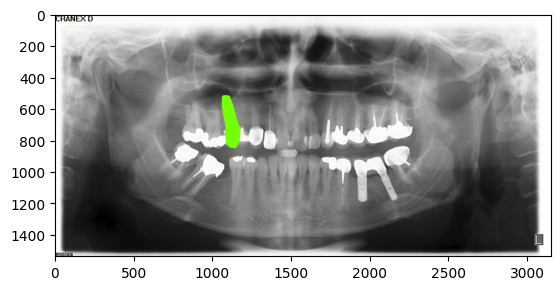

In [ ]:
'''
Check a sample image with it's label
'''
img  = cv2.imread('/content/dataset/images/val/aug_1000012.png')
mask = cv2.imread('/content/dataset/labels/val/aug_1000012.png',0)
print(mask.shape, img.shape)

img[mask == 255] = [118,255,7]

# plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

In [ ]:
'''
At this cell you select an image for inferencing
'''
# Inference
# Define the data transforms
path_ = '/content/dataset/images/val/aug_1000012.png'

transform = transforms.Compose([
    transforms.Resize((img_size_w, img_size_h)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the test image and apply transforms
image = Image.open(path_).convert('RGB')
image = transform(image).to(device)

# Load the model and set to evaluation mode
model.eval()

# Make a prediction on the input image
with torch.no_grad():
    output = model(image.unsqueeze(0))['out']
    pred = output.argmax(dim=1, keepdim=True)

mask_pred = pred.squeeze().cpu().numpy()

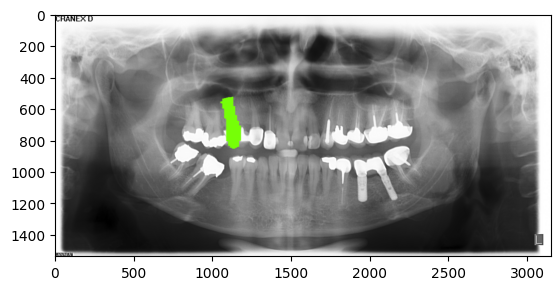

In [ ]:
''' 
So for watching the results 
'''
org_img   = cv2.imread(path_)
mask_pred = cv2.resize(np.uint8(mask_pred), (org_img.shape[1],org_img.shape[0]))   # For seeing result without FC-CRF

org_img[mask_pred == 1] = [118,255,7]

plt.imshow(org_img)
plt.show()

In [ ]:
# Save or load saved losses
train_loss_list_prv = list(np.load('/content/drive/MyDrive/models/dental_seg/deeplab_2/train_40_large.npy')) + train_loss_list
test_loss_list_prv  = list(np.load('/content/drive/MyDrive/models/dental_seg/deeplab_2/test_40_large.npy'))  + test_loss_list

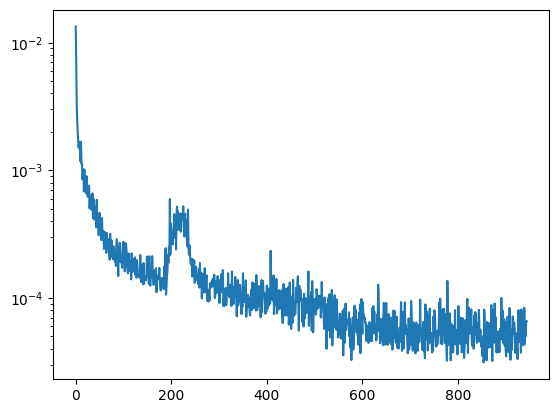

In [ ]:
# Plot train loss
plt.plot(train_loss_list_prv)
plt.yscale('log')
plt.show()

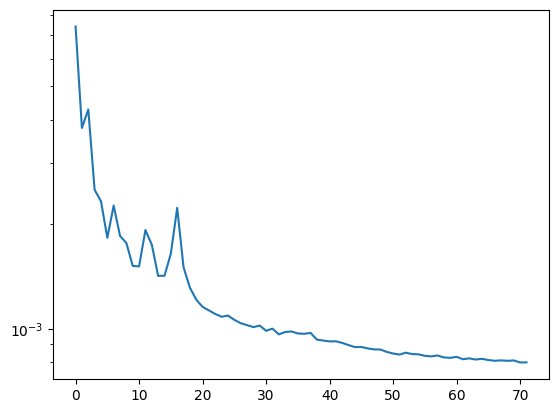

In [ ]:
# Plot test loss
plt.plot(test_loss_list_prv)
plt.yscale('log')
plt.show()


In [ ]:
# Saving losses
np.save('/content/drive/MyDrive/models/dental_seg/deeplab_2/train_72_large.npy', train_loss_list_prv)
np.save('/content/drive/MyDrive/models/dental_seg/deeplab_2/test_72_large.npy', test_loss_list_prv)

In [ ]:
!rm -r '/content/results'
!mkdir '/content/results'

rm: cannot remove '/content/results': No such file or directory


In [ ]:
'''
This Cell will be used to Save test images with it's label and predicted label

NOTE: Don't forget to create a folder with 'results' name
'''
# Test model on test set and save results
model.eval()
for i in range(len(test_dataset)):
  print(i)
  image = test_dataset[i]['image'].to(device)

  with torch.no_grad():
      # Get prediction model
      output = model(image.unsqueeze(0))['out']


      pred = output.argmax(dim=1, keepdim=True)
      mask_pred = pred.squeeze().cpu().numpy()

      # Reading images
      org_img        = cv2.imread(test_dataset[i]['img_path'])
      mask           = cv2.imread(test_dataset[i]['mask_path'],0)
      org_img_copy   = org_img.copy()
      org_img_copy_2 = org_img.copy()

      mask = cv2.resize(mask, (org_img.shape[1], org_img.shape[0]))


      # Find image + predicted mask
      mask_pred = cv2.resize(np.uint8(mask_pred), (org_img.shape[1],org_img.shape[0]))
      org_img[mask_pred == 1] = [118,255,7]
      
      # Find image + label
      org_img_copy[mask == 255] = [118,255,7]

      cv2.imwrite(f'/content/results/{i}.jpg',np.hstack((org_img_copy_2, org_img_copy, org_img)))


  # break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


In [ ]:
!rm -r /content/drive/MyDrive/dental/results_large

In [ ]:
# Use this Cell to make a zip files
!zip -r deeplab_apico.zip ./results

# Test 

In [ ]:
# Find Accuracy and some other parameter for the model
import torch
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize the variables to compute the evaluation metrics
tp = [0] * 2
fp = [0] * 2
tn = [0] * 2
fn = [0] * 2

# Loop through the test data and calculate the confusion matrix
with torch.no_grad():
    for sample in test_loader:
        inputs, targets = sample['image'].to(device), sample['mask'].to(device)

        outputs = model(inputs)['out']
        predicted_labels = torch.argmax(outputs, dim=1)

        gt_labels = targets.squeeze()
        gt_labels = torch.argmax(gt_labels, dim=1)   # SEt changes here 
        
        try:
          cm = confusion_matrix(gt_labels.cpu().flatten().numpy(), predicted_labels.cpu().flatten().numpy(), labels=[0, 1])
        except:
          continue
        for i in range(2):
            tn[i] += sum(cm[j][k] for j in range(2) if j != i for k in range(2) if k != i)
            fp[i] += sum(cm[j][i] for j in range(2) if j != i)
            fn[i] += sum(cm[i][j] for j in range(2) if j != i)
            tp[i] += cm[i][i]


# Calculate the evaluation metrics for each class
precision = [0] * 2
sensitivity = [0] * 2
specificity = [0] * 2
f1_score = [0] * 2
for i in range(2):
    precision[i] = tp[i] / (tp[i] + fp[i])
    sensitivity[i] = tp[i] / (tp[i] + fn[i])
    specificity[i] = tn[i] / (tn[i] + fp[i])
    f1_score[i] = 2 * (precision[i] * sensitivity[i]) / (precision[i] + sensitivity[i])

# Print the results
print('Precision:', precision)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1-score:', f1_score)

# Print the results
print('Precision:', np.mean(precision))
print('Sensitivity:', np.mean(sensitivity))
print('Specificity:', np.mean(specificity))
print('F1-score:', np.mean(f1_score))



Precision: [0.9993768828258401, 0.9369104918952753]
Sensitivity: [0.9992724006869255, 0.9454814750277711]
Specificity: [0.9454814750277711, 0.9992724006869255]
F1-score: [0.999324639025409, 0.9411764705882354]
Precision: 0.9681436873605578
Sensitivity: 0.9723769378573484
Specificity: 0.9723769378573484
F1-score: 0.9702505548068222


In [ ]:
(tp[1] + tn[1]) / (tp[1] + tn[1] + fp[1] + fn[1])

0.9930138385999561

In [ ]:
 # For Check the accuracy with FC-CRF you need the test loader
test_loader_2 = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
import torch
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize the variables to compute the evaluation metrics
tp = [0] * 4
fp = [0] * 4
tn = [0] * 4
fn = [0] * 4

# Loop through the test data and calculate the confusion matrix
with torch.no_grad():
    for sample in test_loader_2:
        inputs, targets = sample['image'].to(device), sample['mask'].to(device)

        image = Image.open(sample['img_path'][0]).convert('RGB')
        image = transform(image).to(device)
        with torch.no_grad():
            output = model(image.unsqueeze(0))['out']

        # outputs = model(inputs)['out']
        image = cv2.imread(sample['img_path'][0])
        image = cv2.resize(image, (224,224))
        predicted_labels  = apply_crf(image, torch.nn.functional.softmax(output, dim=1)[0].cpu().numpy())
        predicted_labels = predicted_labels.unsqueeze(0)
        gt_labels = targets.squeeze()
        gt_labels = torch.argmax(gt_labels, dim=0)   # SEt changes here 
        gt_labels = gt_labels.unsqueeze(0)

        gt_labels = gt_labels.squeeze()
        predicted_labels = predicted_labels.squeeze()

        # print(torch.max(predicted_labels), torch.max(gt_labels))

        try:
          cm = confusion_matrix(gt_labels.cpu().flatten().numpy(), predicted_labels.cpu().flatten().numpy(), labels=[0, 1, 2, 3])
        except:
          continue
        for i in range(4):
            tn[i] += sum(cm[j][k] for j in range(4) if j != i for k in range(4) if k != i)
            fp[i] += sum(cm[j][i] for j in range(4) if j != i)
            fn[i] += sum(cm[i][j] for j in range(4) if j != i)
            tp[i] += cm[i][i]


# Calculate the evaluation metrics for each class
precision = [0] * 4
sensitivity = [0] * 4
specificity = [0] * 4
f1_score = [0] * 4
for i in range(4):
    precision[i] = tp[i] / (tp[i] + fp[i])
    sensitivity[i] = tp[i] / (tp[i] + fn[i])
    specificity[i] = tn[i] / (tn[i] + fp[i])
    f1_score[i] = 2 * (precision[i] * sensitivity[i]) / (precision[i] + sensitivity[i])

# Print the results
print('Precision:', precision)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1-score:', f1_score)

# Print the results
print('Precision:', np.mean(precision))
print('Sensitivity:', np.mean(sensitivity))
print('Specificity:', np.mean(specificity))
print('F1-score:', np.mean(f1_score))


Precision: [0.9948630372136554, 0.727961223871554, 0.9097209240218987, 0.9072041500662009]
Sensitivity: [0.9958502605602942, 0.6672039982262066, 0.9091725958662044, 0.8922657392404063]
Specificity: [0.8207105300925019, 0.9975871691259093, 0.9992166246440355, 0.9991071034332527]
F1-score: [0.9953564040978489, 0.6962596707943314, 0.9094466772938681, 0.8996729385815915]
Precision: 0.8849373337933273
Sensitivity: 0.8661231484732779
Specificity: 0.9541553568239248
F1-score: 0.8751839226919099


# important test

In [ ]:
path = '/content/drive/MyDrive/data/new_test/test/Epico/'
imgs = os.listdir('/content/drive/MyDrive/data/new_test/test/Epico')
imgs = [path + i for i in imgs]
print(imgs)

['/content/drive/MyDrive/data/new_test/test/Epico/new_4171.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4172.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4173.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4174.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4175.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4176.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4177.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4178.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4179.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4180.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4181.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4182.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4183.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4184.png', '/content/drive/MyDrive/data/new_test/test/Epico/new_4185.png', '/content/drive/MyDrive/data/new_test/t

In [ ]:
imgs[0][48:-4]

'new_4171'

In [ ]:
# Inference
# Define the data transforms

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for idx, path_ in enumerate(imgs):
  print(idx, len(imgs))
  # Load the test image and apply transforms
  image = Image.open(path_).convert('RGB')
  image = transform(image).to(device)

  # Load the model and set to evaluation mode
  model.eval()

  # Make a prediction on the input image
  with torch.no_grad():
      output = model(image.unsqueeze(0))['out']
      pred = output.argmax(dim=1, keepdim=True)

  mask_pred = pred.squeeze().cpu().numpy()

  org_img   = cv2.imread(path_)
  mask_pred = cv2.resize(np.uint8(mask_pred), (org_img.shape[1],org_img.shape[0]))   # For seeing result without FC-CRF

  org_img[mask_pred == 1] = [127,0,0]

  cv2.imwrite('./results/'+path_[48:], org_img)

0 159
1 159
2 159
3 159
4 159
5 159
6 159
7 159
8 159
9 159
10 159
11 159
12 159
13 159
14 159
15 159
16 159
17 159
18 159
19 159
20 159
21 159
22 159
23 159
24 159
25 159
26 159
27 159
28 159
29 159
30 159
31 159
32 159
33 159
34 159
35 159
36 159
37 159
38 159
39 159
40 159
41 159
42 159
43 159
44 159
45 159
46 159
47 159
48 159
49 159
50 159
51 159
52 159
53 159
54 159
55 159
56 159
57 159
58 159
59 159
60 159
61 159
62 159
63 159
64 159
65 159
66 159
67 159
68 159
69 159
70 159
71 159
72 159
73 159
74 159
75 159
76 159
77 159
78 159
79 159
80 159
81 159
82 159
83 159
84 159
85 159
86 159
87 159
88 159
89 159
90 159
91 159
92 159
93 159
94 159
95 159
96 159
97 159
98 159
99 159
100 159
101 159
102 159
103 159
104 159
105 159
106 159
107 159
108 159
109 159
110 159
111 159
112 159
113 159
114 159
115 159
116 159
117 159
118 159
119 159
120 159
121 159
122 159
123 159
124 159
125 159
126 159
127 159
128 159
129 159
130 159
131 159
132 159
133 159
134 159
135 159
136 159
137 159
138 15

In [ ]:
!rm -r 'results'

In [ ]:
!mkdir 'results'

In [ ]:
# Use this Cell to make a zip files
!zip -r deeplab_epico.zip ./results
